In [50]:
import ijson
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns

In [51]:
# set options for pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

In [52]:
def extract_json_data_into_dataframe(json_file_path: str, no_of_entries: int, from_index: int) -> pd.DataFrame:
    """
    extracts the json data from the json file and returns a pandas dataframe
    :param json_file_path: path to the json file
    :param no_of_entries: number of entries to be extracted from the json file
    :param from_index: index from which the entries should be extracted
    :return: pandas dataframe containing the extracted data
    """
    df = pd.DataFrame()

    f = open(json_file_path, 'r')
    for i, json_event in enumerate(ijson.items(f, 'item')):
        if i < from_index:
            continue
        if i >= from_index and i < (from_index + no_of_entries): 
            single_df = pd.json_normalize(json_event)
            df = pd.concat([df, single_df], ignore_index=True)
        else:
            break
            
    f.close()

    return df

df = extract_json_data_into_dataframe('stuttgart_events.json', 1000, 2000)


# Data Preprocessing

## Remove all events that take place at locations not in Stuttgart

In [53]:
def remove_events_not_in_stuttgart(df: pd.DataFrame) -> pd.DataFrame:
    """
    Remove all events not in Stuttgart by looking at the evntData.location.location.city column
    :param df: dataframe containing the events
    :return: dataframe containing only events in Stuttgart (might be the same as inpt df)
    """
    df = df[df['eventData.location.location.address.city'] == 'Stuttgart']
    return df

df = remove_events_not_in_stuttgart(df)

In [54]:
print(df.shape)

(1000, 100)


### Check for NA values

In [55]:
# check for NA values
print(df.isna().sum())

id                                                             0
hostname                                                       0
webpageId                                                   1000
eventData.name                                                 0
eventData.description                                          7
eventData.sourceId                                             0
eventData.url                                                  0
eventData.startDate                                            0
eventData.endDate                                            995
eventData.doorTime                                          1000
eventData.cancelled                                            0
eventData.location.sourceId                                    5
eventData.location.url                                         5
eventData.location.name                                        0
eventData.location.description                               995
eventData.location.locati

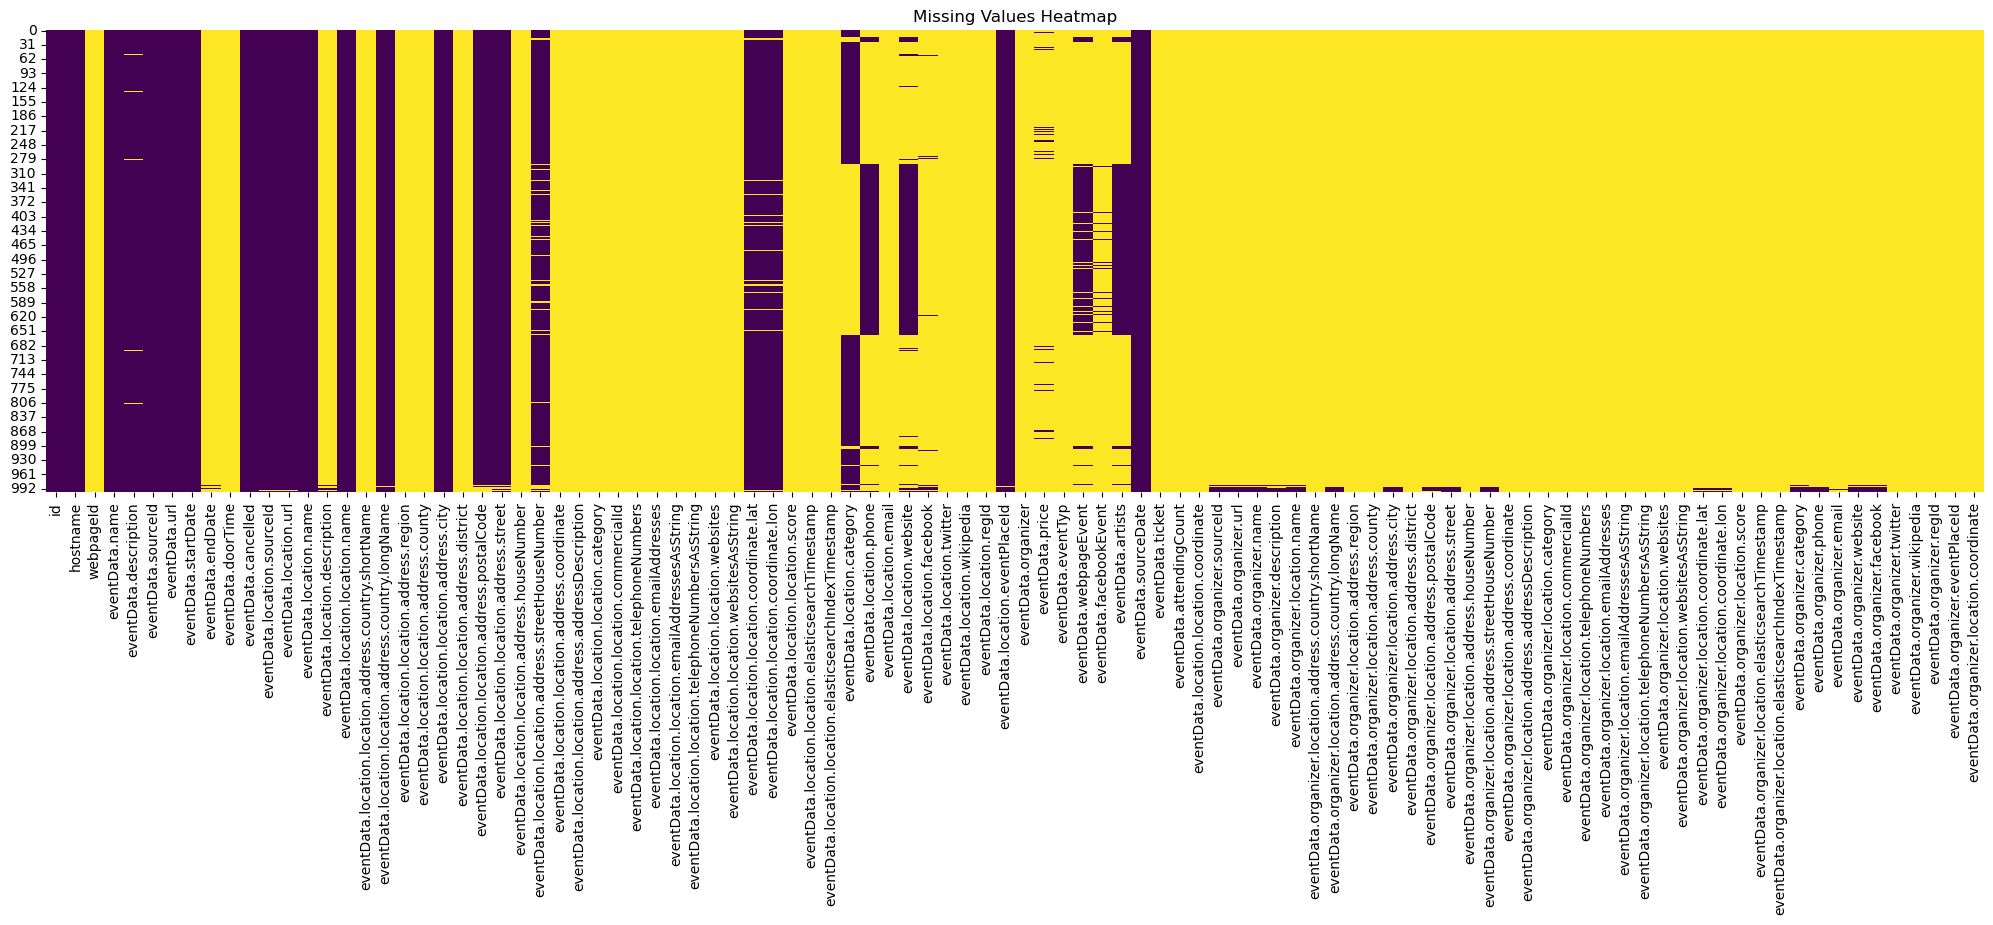

In [56]:
# Create a heatmap of missing values
plt.figure(figsize=(25, 6))  # Adjust the figure size as needed
sns.heatmap(df.isnull(), cmap='viridis', cbar=False)
plt.title('Missing Values Heatmap')
plt.show()

Interpretation: The yellow area shows the NA values. There is a lot of missing data 😨

In [57]:
# delete columns with more than 10% missing values
df = df[df.columns[df.isnull().mean() < 0.80]]
print(df.shape)

(1000, 26)


We just deleted a ton of columns because they all contain a lot of missing values and are probably not helpful for further analysis.

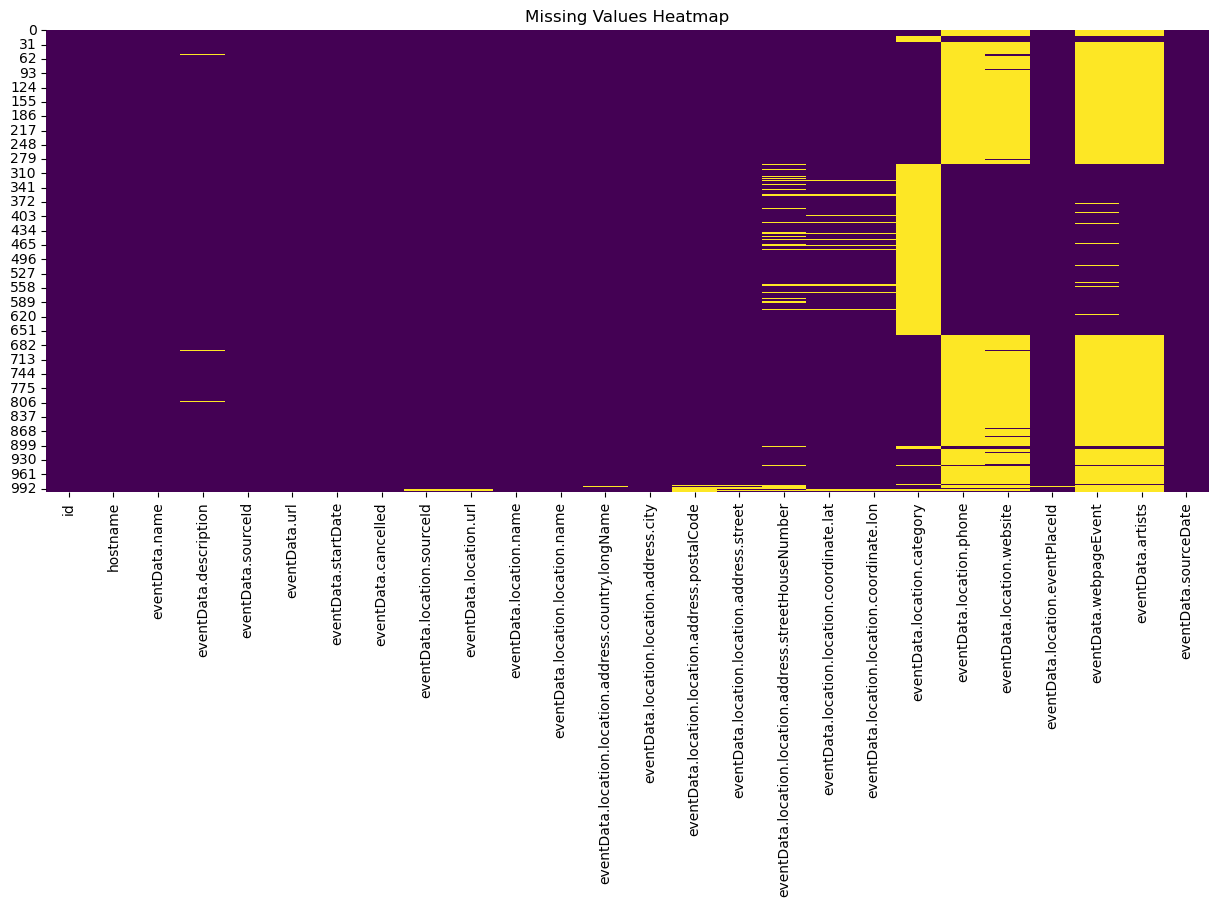

In [58]:
# again plot missing values after cleaning
plt.figure(figsize=(15, 6))  # Adjust the figure size as needed
sns.heatmap(df.isnull(), cmap='viridis', cbar=False)
plt.title('Missing Values Heatmap')
plt.show()

Only latitude and longitude still contain missing values which is quite good. The missing values also always come together.

In [59]:
# check datatypes
print(df.dtypes)

id                                                       object
hostname                                                 object
eventData.name                                           object
eventData.description                                    object
eventData.sourceId                                       object
eventData.url                                            object
eventData.startDate                                      object
eventData.cancelled                                        bool
eventData.location.sourceId                              object
eventData.location.url                                   object
eventData.location.name                                  object
eventData.location.location.name                         object
eventData.location.location.address.country.longName     object
eventData.location.location.address.city                 object
eventData.location.location.address.postalCode           object
eventData.location.location.address.stre

In [60]:
print(df.loc[50,])

id                                                                                                                                                                                                                                                                                                                 prinz.de/stuttgart/events/442966-peilsender-1
hostname                                                                                                                                                                                                                                                                                                                                                prinz.de
eventData.name                                                                                                                                                                                                                                                                                        

In [61]:
# delete all events which were cancelled
df = df[df['eventData.cancelled'] == False]

In [68]:
df['eventData.startDate']

0            2013-06-07 11:00:00
1            2014-01-16 03:30:00
2            2014-02-22 09:00:00
3            2014-03-29 01:00:00
4            2014-02-26 08:00:00
5            2014-03-08 10:00:00
6            2014-03-28 10:00:00
7            2014-05-29 08:00:00
8            2014-05-22 10:00:00
9            2014-05-07 08:00:00
10           2014-05-17 02:00:00
11           2014-05-18 08:15:00
12           2014-06-07 02:00:00
13           2014-12-08 10:00:00
14           2013-02-14 20:00:00
15           2013-02-08 23:00:00
16           2013-02-16 23:00:00
17           2013-02-23 20:00:00
18           2014-04-25 23:00:00
19           2014-04-30 20:00:00
20           2014-06-20 23:00:00
21           2007-12-21 21:00:00
22           2014-08-09 23:00:00
23           2014-09-26 19:50:01
24           2014-10-18 15:52:01
25           2014-12-20 08:00:00
26           2015-02-20 08:30:00
27           2013-05-10 08:00:00
28           2013-02-26 07:00:00
29           2013-01-19 07:30:00
30        

# Feature Engineering

In [69]:
# Convert the date columns to datetime
df['eventData.startDate'] = pd.to_datetime(df['eventData.startDate'], format='mixed', utc=True)
try:
    df['eventData.sourceDate'] = pd.to_datetime(df['eventData.sourceDate'], format='mixed', errors='coerce')
except:
    print('eventData.sourceDate could not be converted to datetime')


In [70]:
df['eventData.startDate']

0     2013-06-07 11:00:00+00:00
1     2014-01-16 03:30:00+00:00
2     2014-02-22 09:00:00+00:00
3     2014-03-29 01:00:00+00:00
4     2014-02-26 08:00:00+00:00
5     2014-03-08 10:00:00+00:00
6     2014-03-28 10:00:00+00:00
7     2014-05-29 08:00:00+00:00
8     2014-05-22 10:00:00+00:00
9     2014-05-07 08:00:00+00:00
10    2014-05-17 02:00:00+00:00
11    2014-05-18 08:15:00+00:00
12    2014-06-07 02:00:00+00:00
13    2014-12-08 10:00:00+00:00
14    2013-02-14 20:00:00+00:00
15    2013-02-08 23:00:00+00:00
16    2013-02-16 23:00:00+00:00
17    2013-02-23 20:00:00+00:00
18    2014-04-25 23:00:00+00:00
19    2014-04-30 20:00:00+00:00
20    2014-06-20 23:00:00+00:00
21    2007-12-21 21:00:00+00:00
22    2014-08-09 23:00:00+00:00
23    2014-09-26 19:50:01+00:00
24    2014-10-18 15:52:01+00:00
25    2014-12-20 08:00:00+00:00
26    2015-02-20 08:30:00+00:00
27    2013-05-10 08:00:00+00:00
28    2013-02-26 07:00:00+00:00
29    2013-01-19 07:30:00+00:00
30    2013-01-22 08:00:00+00:00
31    20

In [71]:
# add a column for the day of the week by using the startDate column
df['dayofweek'] = df['eventData.startDate'].dt.dayofweek


In [72]:
print(df['dayofweek'].value_counts())

dayofweek
5    297
4    206
3    139
2    129
6     95
1     67
0     55
Name: count, dtype: int64


Apparently, 0 means Monday, 1 means Tuesday, 2 means Wednesday and so on...
We only want to have information about events on Wednesdays, so number 2.

In [73]:
# only consider Wednesdays and drop all other days
df = df[df['dayofweek'] == 2]
df.reset_index(drop=True, inplace=True)
df.shape

(129, 27)

In [74]:
# Create a year column
df['year'] = df['eventData.startDate'].dt.year

/tmp/ipykernel_2616/3903919923.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['year'] = df['eventData.startDate'].dt.year


In [75]:
# Create a month column
df['month'] = df['eventData.startDate'].dt.month

/tmp/ipykernel_2616/3401658585.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['month'] = df['eventData.startDate'].dt.month


In [76]:
# Create feature season

# create a function to determine the season
def get_season(date: pd.Timestamp) -> str:
    """
    returns the season of a given date
    :param date: date for which the season should be determined
    :return: season of the given date
    """
    # spring
    if date.month >= 3 and date.month <= 5:
        return 'spring'
    # summer
    elif date.month >= 6 and date.month <= 8:
        return 'summer'
    # autumn
    elif date.month >= 9 and date.month <= 11:
        return 'autumn'
    # winter
    else:
        return 'winter'

# apply the function to the startDate column
df['season'] = df['eventData.startDate'].apply(get_season)

/tmp/ipykernel_2616/3986564594.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['season'] = df['eventData.startDate'].apply(get_season)


In [77]:
df['eventData.location.location.address.postalCode'].value_counts()

eventData.location.location.address.postalCode
70173    37
70178    28
70174    12
70191    11
          7
70193     7
70372     6
70469     6
70192     3
70188     2
70327     2
70180     2
70199     1
70435     1
70182     1
70567     1
Name: count, dtype: int64

In [78]:
# instead of having to choose location based on postcal code, it would be way nicer to choose location based on district
# therefore we need to add a column containing the district of the event
# we can get the district by using a mapping from postcal code to district
# https://home.meinestadt.de/stuttgart/postleitzahlen

zip_code_to_district = {
    "70173": "Europaviertel",
    "70174": "Relenberg",
    "70178": "Karlshöhe",
    "70191": "Am Rosensteinpark",
    "70193": "Kräherwald",
    "70195": "Botnang-West",
    "70197": "Vogelsang",
    "70199": "Südheim",
    "70372": "Bad Cannstatt",
    "70567": "Sternhäule",
    "70569": "Pfaffenwald",
    "70437": "Freiberg",
    "70176": "Rosenberg",
    "70188": "Uhlandshöhe",
    "70374": "Im Geiger",
    "70439": "Zuffenhausen-Elbelen",
    "70190": "Stöckach",
    "70180": "Weinsteige",
    "70182": "Heusteigviertel",
    "70376": "Neckarvorstadt",
    "70378": "Mönchfeld",
    "70597": "Waldau",
    "70565": "Möhringen-Süd",
    "70469": "Feuerbach-Ost",
    "70199": "Südheim"
}


def get_district_from_postcal_code(postcalCode: int):
    """
    returns the district of a given postal code
    :param postcalCode: postal code for which the district should be determined
    :return: district of the given postal code
    """
    try:
        district = zip_code_to_district[str(postcalCode)]
    except KeyError:
        district = "Other"
    return district
    
# apply the function to the postal code column
df['district'] = df['eventData.location.location.address.postalCode'].apply(get_district_from_postcal_code)
    

/tmp/ipykernel_2616/536182790.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['district'] = df['eventData.location.location.address.postalCode'].apply(get_district_from_postcal_code)


There are basically two types of categories:
- super-category: determines the main function of the event
    - konzert
    - kultur
    - stadtleben
    - party
    - familie
- sub-category: For each super-category there are multiple sub-categories --> Might be cool to also have them on display when showing the event.

In [79]:
# create features supercategory and subcategory
# split entry in eventData.location.category by / 
def extract_categories(df: pd.DataFrame):
    """
    extracts the supercategory and subcategory from the eventData.location.category column
    :param df: dataframe containing the events
    :return: dataframe containing the events with two new columns supercategory and subcategory
    """
    df['supercategory'] = np.where(df['eventData.location.category'].notnull(), df['eventData.location.category'].str.split('/').str[0], 'anderes')
    df['subcategory'] = np.where(df['eventData.location.category'].notnull(), df['eventData.location.category'].str.split('/').str[1], 'anderes')
    return df

df = extract_categories(df)


/tmp/ipykernel_2616/664959420.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['supercategory'] = np.where(df['eventData.location.category'].notnull(), df['eventData.location.category'].str.split('/').str[0], 'anderes')
/tmp/ipykernel_2616/664959420.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['subcategory'] = np.where(df['eventData.location.category'].notnull(), df['eventData.location.category'].str.split('/').str[1], 'anderes')


In [80]:
# Would be great to get the starting time of the events in a separate column
df["starting_hour"]=df["eventData.startDate"].dt.time

/tmp/ipykernel_2616/163515699.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["starting_hour"]=df["eventData.startDate"].dt.time


In [81]:
# create a column that classifies the events into morning, afternoon and evening
def get_time_of_day(time: pd.Timestamp) -> str:
    """
    returns the time of day of a given start time
    :param time: time for which the time of day should be determined
    :return: time of day of the given time
    """
    # morning
    if time.hour >= 6 and time.hour < 12:
        return 'Morning'
    # afternoon
    elif time.hour >= 12 and time.hour < 18:
        return 'Afternoon'
    # evening
    elif time.hour >= 18 and time.hour < 24:
        return 'Evening'
    # night
    else:
        return 'Night'
    
# apply the function to the starting_hour column
df['time_of_day'] = df['starting_hour'].apply(get_time_of_day)

/tmp/ipykernel_2616/3402819901.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['time_of_day'] = df['starting_hour'].apply(get_time_of_day)


# Save dataframe to csv

In [82]:
# save output df to csv
df.to_csv('3000Events.csv', index=False)